Necessary imports

In [ ]:
import os, sys
import pandas as pd

module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from packages.bicpy import gene2pattern, bicpy
from packages.mylib import myproject
from packages.tcgahandler import LayerDataset
from packages.pydge import pydge
import matplotlib.pyplot as plt
import seaborn as sns
import umap
from sklearn.feature_selection import mutual_info_classif
import numpy as np
import matplotlib.patches as  mpatches

DATA_DIR = "../../data/"

Define necessary variables

In [2]:
# parameterization for biclustering algorithm
# default parameters out of scope for this work
default_param = {
    'symmetries': False,
    'normalization': "column",
    'discretization': "normal_distribution",
    'noise_relaxation': "optional",
    'filling_criteria': "remove",
    'pattern_type': "constant",
    'orientation': "rows",
    'remove_percentage': 0.1,
    "to_posthandle": True,
    "balancing": False
}
# relevant parameters defined
params = {"min_biclusters": 10, "min_columns": 3, "min_lift": 1.2, "nr_iterations": 10, "nr_labels": 11, }

# plot variables
sns.set_theme()
sns.set_style("darkgrid", {"axes.facecolor": ".9"})
dpi = 200

target = "vital_status"

# Data Space 2D

Function to transform and plot data space in 2D

In [3]:
def separability_space(project, layer, target, parameterization, distance="norm_euclidean"):
    """Transforms gene-centric and pattern-centric datasets to 2D using UMAP
    
    Parameters
    ----------
    project : str
        TCGA project to use
    layer : str
        omics layer to use
    target : str
        Target variable for color coding
    parameterization: dict
        Parameterization for the biclustering algorithm
    distance : str
        Distance used to calculate new values of pattern-centric data

    Returns
    --------
    list[pd.DataFrame]
        A list with two DataFrames representing the gene-centric and pattern-centric data in 2D

    """
    
    reducers = {"umap": umap.UMAP(n_components=2)}
    discretize_parameters = ["nr_labels", "symmetries", "normalization", "discretization", "noise_relaxation", "filling_criteria"]

    dataset = LayerDataset(DATA_DIR, project, layer)
    data = dataset.get_data_with_target(data_type='default', target=target)
    if layer != 'protein':
        counts = dataset.get_data_with_target(data_type='counts', target=target)
        filtered_genes = pydge.deg_filtering(counts, target, filter_only=True)
        data = data[filtered_genes + [target]]
        data = dataset.log_transform_data(data, target, data_type="default")

    discretize_parameterization = {key: value for key, value in parameterization.items() if key in discretize_parameters}
    discrete_data, intscores = bicpy.discretize_data(data, discretize_parameterization, verbose=0)         
    discrete_data[target] = data[target]
    patterns = bicpy.run(parameterization,  discrete_data, discretize=False, intscores=intscores)
    pattern_data = gene2pattern.create_pattern_dataset(discrete_data, target, patterns, parameterization, distance, None, None)

    res = []
    for i, (key, d) in enumerate({"Normal": data, "Pattern-Based": pattern_data}.items()):
        reducer = reducers["umap"]
        # Fit and transform data
        reduced_features = reducer.fit_transform(d.drop(columns=[target]).values)
        # Create dataframe
        red_df = pd.DataFrame(data=reduced_features, columns=['PC1', 'PC2'], index=d.index)
        red_df[target] = d[target]
        res.append(red_df)

    return res

## TCGA-LGG

Generate 2D data spaces

In [4]:
projects = "TCGA-LGG"
layers = 'mrna'
parameterization = bicpy.add_default_parameterization(params, default_param)
data, pattern_data = separability_space(projects, layers, target, parameterization)

No file with values to replace. Continuing.
No file with values to replace. Continuing.


Plot

([<matplotlib.collections.PathCollection object at 0x7ff599ed31d0>, <matplotlib.collections.PathCollection object at 0x7ff59cbd53d0>], ['Deceased', 'Alive'])


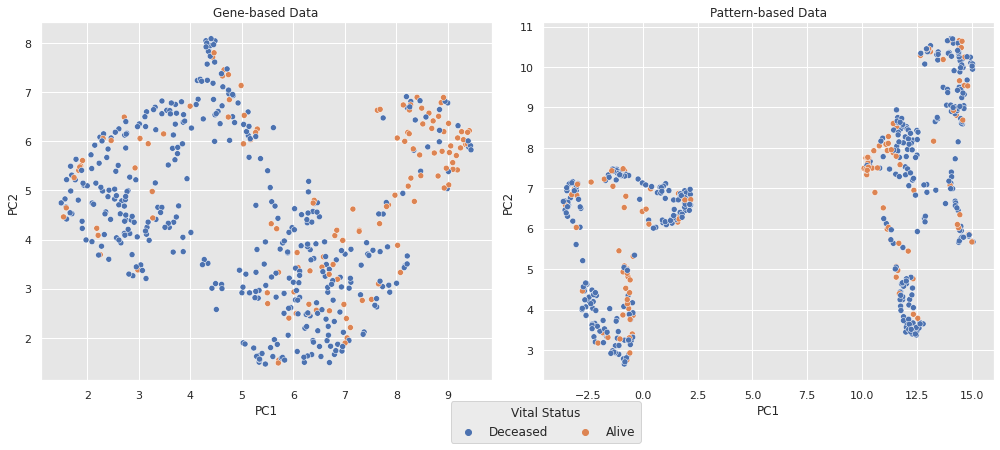

In [5]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6), tight_layout=True)
data[target] = data[target].replace({0: "Deceased", 1: "Alive"})
pattern_data[target] = pattern_data[target].replace({0: "Deceased", 1: "Alive"})

sns.scatterplot(data=data, x="PC1", y="PC2", hue=target, ax=axes[0])
print(axes[0].get_legend_handles_labels())
axes[0].set_title("Gene-based Data", fontsize="large")
handles, labels = axes[0].get_legend_handles_labels()
axes[0].get_legend().remove()

sns.scatterplot(data=pattern_data, x="PC1", y="PC2", hue=target, ax=axes[1])
axes[1].set_title("Pattern-based Data", fontsize="large")
handles, labels = axes[1].get_legend_handles_labels()
axes[1].get_legend().remove()

fig.legend(handles, labels, bbox_to_anchor=(0.645, 0.075), ncol=len(labels), fontsize='large', title="Vital Status", title_fontsize='large')
plt.show()

## TCGA-COAD

Generate 2D data spaces

In [6]:
projects = "TCGA-COAD"
layers = 'mrna'
dim_reduction = 'umap'
parameterization = bicpy.add_default_parameterization(params, default_param)
data, pattern_data = separability_space(projects, layers, target, parameterization)

No file with values to replace. Continuing.
No file with values to replace. Continuing.


Plot

([<matplotlib.collections.PathCollection object at 0x7ff584f3b1d0>, <matplotlib.collections.PathCollection object at 0x7ff584f0a9d0>], ['Deceased', 'Alive'])


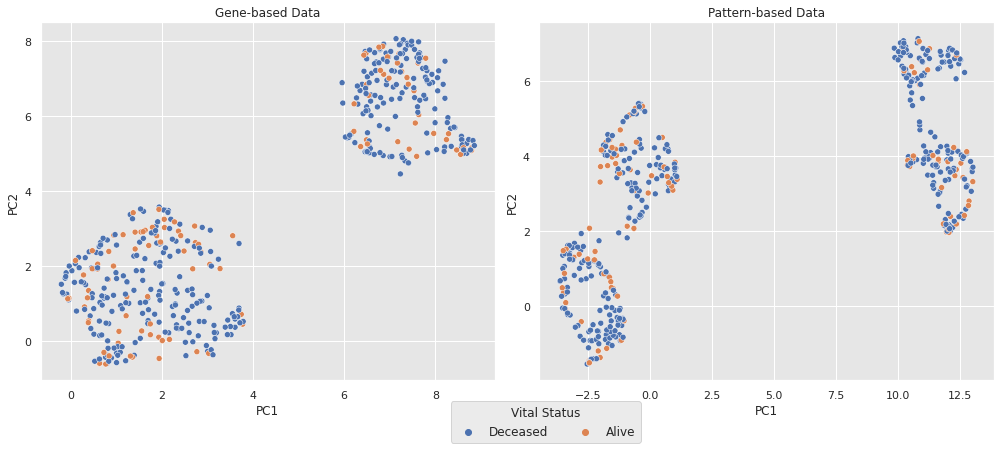

In [7]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6), tight_layout=True)
data[target] = data[target].replace({0: "Deceased", 1: "Alive"})
pattern_data[target] = pattern_data[target].replace({0: "Deceased", 1: "Alive"})

sns.scatterplot(data=data, x="PC1", y="PC2", hue=target, ax=axes[0])
print(axes[0].get_legend_handles_labels())
axes[0].set_title("Gene-based Data", fontsize="large")
handles, labels = axes[0].get_legend_handles_labels()
axes[0].get_legend().remove()

sns.scatterplot(data=pattern_data, x="PC1", y="PC2", hue=target, ax=axes[1])
axes[1].set_title("Pattern-based Data", fontsize="large")
handles, labels = axes[1].get_legend_handles_labels()
axes[1].get_legend().remove()

fig.legend(handles, labels, bbox_to_anchor=(0.645, 0.075), ncol=len(labels), fontsize='large', title="Vital Status", title_fontsize='large')
plt.show()

# Conditional Plots

Function to identify discriminative variables according to Mutual Information and plot conditional distributions

In [8]:
def conditional_distributions(project, layer, target, parameterization, n_vars, distance="norm_euclidean", rs=3):
    """Identifies top discriminative variables and plots their conditional distribution
    
    Parameters
    ----------
    project : str
        TCGA project to use
    layer : str
        omics layer to use
    target : str
        Target variable for the conditional distribution
    parameterization : dict
        Parameterization for the biclustering algorithm
    n_vars : int
        Number of variables to select and plot
    distance : str
        Distance used to calculate new values of pattern-centric data
    rs : int
        Random state
    """

    discretize_parameters = ["nr_labels", "symmetries", "normalization", "discretization", "noise_relaxation", "filling_criteria"]
    
    dataset = LayerDataset(DATA_DIR, project, layer)
    data = dataset.get_data_with_target(data_type='default', target=target)
    if dataset.layer != 'protein':
        counts = dataset.get_data_with_target(data_type='counts', target=target)
        filtered_genes = pydge.deg_filtering(counts, target, filter_only=True)
        data = dataset.log_transform_data(data, target, data_type="default")
    else:
        counts = None
        filtered_genes = data.drop(columns=[target]).columns.tolist()

    # Pattern data
    discretize_parameterization = {key: value for key, value in parameterization.items() if key in discretize_parameters}
    discrete_data, intscores = bicpy.discretize_data(data[filtered_genes + [target]], discretize_parameterization, verbose=0)         
    discrete_data[target] = data[target]
    patterns = bicpy.run(parameterization,  discrete_data, discretize=False, intscores=intscores)
    pattern_data = gene2pattern.create_pattern_dataset(discrete_data, target, patterns, parameterization, distance, None, None)

    # DEG data
    if dataset.layer == 'mrna':
        variables = pydge.deg_filtering(counts, target, pvalue=0.05)
        deg_data = data[variables + [target]]
    else:
        deg_data = data

    # Get top n_vars acording to MI
    mi_values = mutual_info_classif(pattern_data.drop(columns=[target]).values, pattern_data[target].values, random_state=rs)
    ind = np.argpartition(mi_values, n_vars)[-n_vars:]
    ind = mi_values.argsort()[-n_vars:][::-1]
    pattern_top_vars = pattern_data.columns[ind].tolist()
    print("Pattern-based vars: ", pattern_top_vars)
    mi_values = mutual_info_classif(deg_data.drop(columns=[target]).values, deg_data[target].values, random_state=rs)
    ind = np.argpartition(mi_values, n_vars)[-n_vars:]
    deg_top_vars = deg_data.columns[ind].tolist()
    print("Gene-based vars:", deg_top_vars)

    return deg_data, deg_top_vars, pattern_data, pattern_top_vars, patterns

## TCGA-LGG

In [9]:
n_vars = 5
layer = "mrna"
projects = "TCGA-LGG"
parameterization = bicpy.add_default_parameterization(params, default_param)
data, top_vars, pattern_data, pattern_top_vars, patterns = conditional_distributions(projects, layer, target, parameterization, n_vars)

No file with values to replace. Continuing.
No file with values to replace. Continuing.
Pattern-based vars:  ['p29', 'p15', 'p330', 'p8', 'p17']
Gene-based vars: ['ENSG00000037897.17', 'ENSG00000255737.2', 'ENSG00000170677.6', 'ENSG00000130600.19', 'ENSG00000111012.10']


In [10]:
pattern_inds = [int(pat.strip('p')) - 1 for pat in pattern_top_vars]
for ind in pattern_inds:
    pattern = patterns[ind]
    print("p",ind+1)
    print("Cols:", pattern.columns)
    print("Values:", pattern.values)
    print("N samples:", len(pattern.rows))
    print("Lift:", pattern.lift)
    print()

p 29
Cols: ['ENSG00000142227.11', 'ENSG00000133048.13', 'ENSG00000104611.12']
Values: [10, 10, 10]
N samples: 52
Lift: [0.5095162569389374, 2.5103785103785103]

p 15
Cols: ['ENSG00000102265.12', 'ENSG00000158710.15', 'ENSG00000142227.11']
Values: [10, 10, 10]
N samples: 54
Lift: [0.46611302023673157, 2.6440329218106995]

p 330
Cols: ['ENSG00000122592.8', 'ENSG00000240990.10', 'ENSG00000133636.11']
Values: [4, 4, 3]
N samples: 77
Lift: [1.2215155978042578, 0.3178726035868893]

p 8
Cols: ['ENSG00000109113.20', 'ENSG00000158156.9', 'ENSG00000161798.7']
Values: [10, 10, 10]
N samples: 59
Lift: [0.6286912458500787, 2.1433952111918213]

p 17
Cols: ['ENSG00000179299.17', 'ENSG00000173040.13', 'ENSG00000012211.13']
Values: [10, 10, 10]
N samples: 53
Lift: [0.47490760552421707, 2.6169511829889194]



/tmp/ipykernel_102107/2510996982.py:8: UserWarning: The Figure parameters 'tight_layout' and 'constrained_layout' cannot be used together. Please use 'layout' parameter
  fig, axes = plt.subplots(nrows=2, ncols=n_vars, figsize=(22, 8), tight_layout=False, constrained_layout=True)


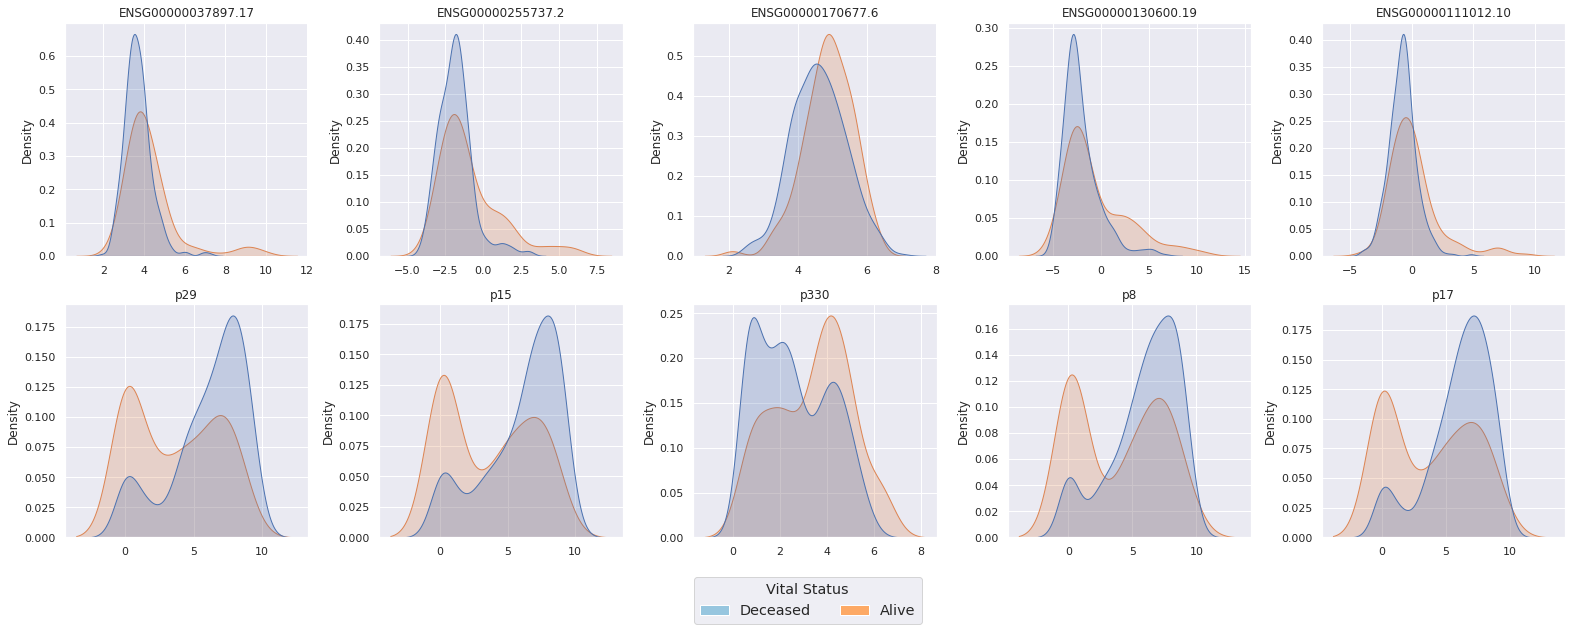

In [11]:
data[target] = data[target].replace({0: "Deceased", 1: "Alive"})
tdata = data.rename(columns={"vital_status": "Vital Status"})

pattern_data[target] = pattern_data[target].replace({0: "Deceased", 1: "Alive"})
tpattern_data = pattern_data.rename(columns={"vital_status": "Vital Status"})

sns.set()
fig, axes = plt.subplots(nrows=2, ncols=n_vars, figsize=(22, 8), tight_layout=False, constrained_layout=True)
for i, var in enumerate(top_vars):
    sns.kdeplot(data=tdata, x=var, hue="Vital Status", fill=True, ax=axes[0,i], common_norm=False)
    axes[0,i].set_title(var)
    axes[0,i].set(xlabel=None)
    axes[0,i].get_legend().remove()

locations = ["upper left", "upper left", "upper right", "upper left", "upper left"]
for i, var in enumerate(pattern_top_vars):
    sns.kdeplot(data=tpattern_data, x=var, hue="Vital Status", fill=True, ax=axes[1,i], common_norm=False)
    axes[1,i].set_title(var)
    axes[1,i].set(xlabel=None)
    axes[1,i].get_legend().remove()

pattern_ind = int(pattern_top_vars[1].strip('p')) - 1
pattern = patterns[i]
labels = ["Deceased", "Alive"]
handles = [
            mpatches.Patch(facecolor=plt.cm.Blues(100)),
            mpatches.Patch(facecolor=plt.cm.Oranges(100)),
            ]
fig.legend(handles, labels, bbox_to_anchor=(0.59, 0), ncol=len(labels), fontsize='large',title="Vital Status", title_fontsize='large')
plt.show()

## TCGA-COAD

In [12]:
n_vars = 5
layer = "mrna"
projects = "TCGA-COAD"
parameterization = bicpy.add_default_parameterization(params, default_param)
data, top_vars, pattern_data, pattern_top_vars, patterns = conditional_distributions(projects, layer, target, parameterization, n_vars)

No file with values to replace. Continuing.
No file with values to replace. Continuing.
Pattern-based vars:  ['p298', 'p345', 'p51', 'p373', 'p413']
Gene-based vars: ['ENSG00000243566.7', 'ENSG00000160201.12', 'ENSG00000143502.15', 'ENSG00000163017.14', 'ENSG00000260593.1']


In [13]:
pattern_inds = [int(pat.strip('p')) - 1 for pat in pattern_top_vars]
for ind in pattern_inds:
    pattern = patterns[ind]
    print("p",ind+1)
    print("Cols:", pattern.columns)
    print("Values:", pattern.values)
    print("N samples:", len(pattern.rows))
    print("Lift:", pattern.lift)
    print()

p 298
Cols: ['ENSG00000287388.1', 'ENSG00000257185.2', 'ENSG00000228695.10']
Values: [2, 6, 5]
N samples: 84
Lift: [0.9047619047619049, 1.3305322128851542]

p 345
Cols: ['ENSG00000253553.7', 'ENSG00000186086.18', 'ENSG00000261502.4']
Values: [8, 5, 6]
N samples: 67
Lift: [0.9036175056918796, 1.3345039508340646]

p 51
Cols: ['ENSG00000241566.1', 'ENSG00000254056.1', 'ENSG00000259680.5']
Values: [1, 0, 1]
N samples: 57
Lift: [0.9265536723163842, 1.2549019607843137]

p 373
Cols: ['ENSG00000240086.7', 'ENSG00000253553.7', 'ENSG00000274840.4']
Values: [8, 8, 2]
N samples: 74
Lift: [0.9225836005497022, 1.2686804451510334]

p 413
Cols: ['ENSG00000180178.11', 'ENSG00000134538.3', 'ENSG00000261520.5']
Values: [6, 5, 5]
N samples: 74
Lift: [1.201099404489235, 0.3020667726550079]



/tmp/ipykernel_102107/2510996982.py:8: UserWarning: The Figure parameters 'tight_layout' and 'constrained_layout' cannot be used together. Please use 'layout' parameter
  fig, axes = plt.subplots(nrows=2, ncols=n_vars, figsize=(22, 8), tight_layout=False, constrained_layout=True)


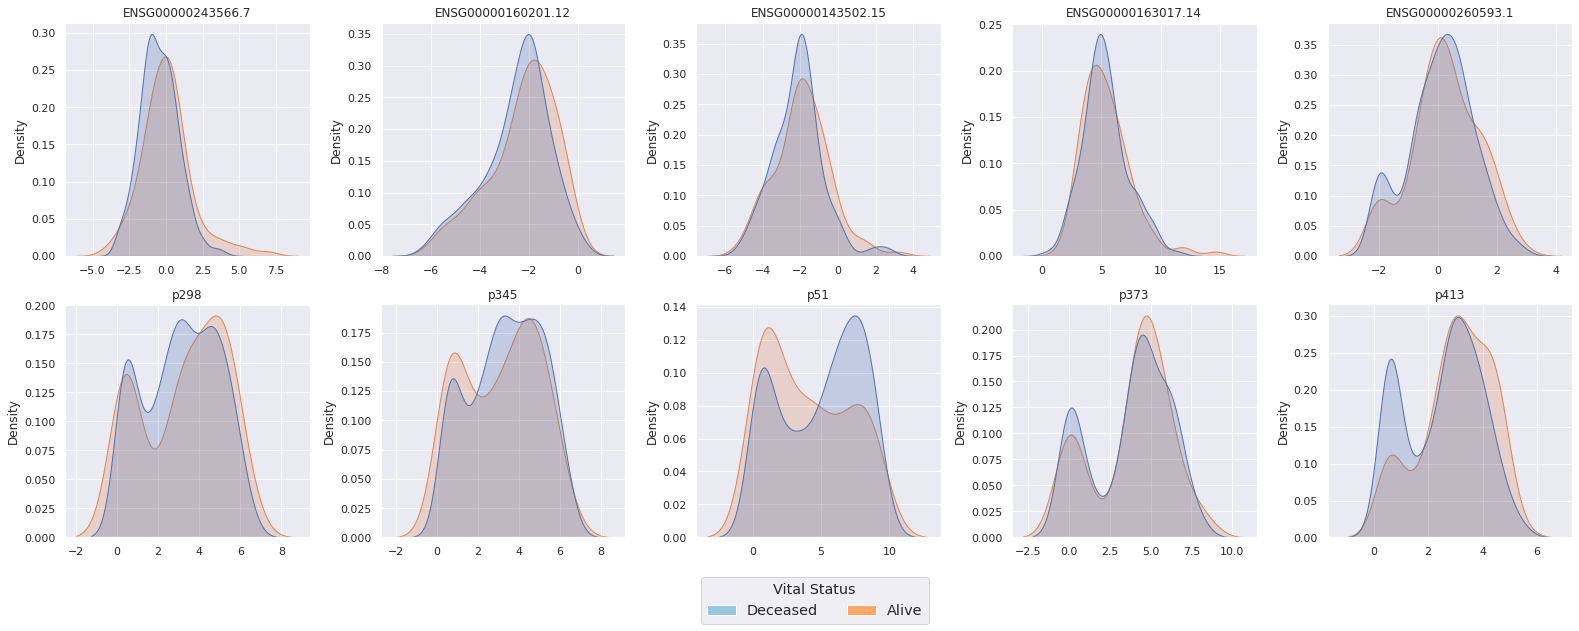

In [14]:
data[target] = data[target].replace({0: "Deceased", 1: "Alive"})
tdata = data.rename(columns={"vital_status": "Vital Status"})

pattern_data[target] = pattern_data[target].replace({0: "Deceased", 1: "Alive"})
tpattern_data = pattern_data.rename(columns={"vital_status": "Vital Status"})

sns.set()
fig, axes = plt.subplots(nrows=2, ncols=n_vars, figsize=(22, 8), tight_layout=False, constrained_layout=True)
for i, var in enumerate(top_vars):
    sns.kdeplot(data=tdata, x=var, hue="Vital Status", fill=True, ax=axes[0,i], common_norm=False)
    axes[0,i].set_title(var)
    axes[0,i].set(xlabel=None)
    axes[0,i].get_legend().remove()

locations = ["upper left", "upper left", "upper right", "upper left", "upper left"]
for i, var in enumerate(pattern_top_vars):
    sns.kdeplot(data=tpattern_data, x=var, hue="Vital Status", fill=True, ax=axes[1,i], common_norm=False)
    axes[1,i].set_title(var)
    axes[1,i].set(xlabel=None)
    axes[1,i].get_legend().remove()

pattern_ind = int(pattern_top_vars[1].strip('p')) - 1
pattern = patterns[i]
labels = ["Deceased", "Alive"]
handles = [
            mpatches.Patch(facecolor=plt.cm.Blues(100)),
            mpatches.Patch(facecolor=plt.cm.Oranges(100)),
            ]
fig.legend(handles, labels, bbox_to_anchor=(0.59, 0), ncol=len(labels), fontsize='large',title="Vital Status", title_fontsize='large')
plt.show()